# Ocean PAMA-seq and metagenomic subsampling analysis

### Objective
1. PAMA-seq requires less sequencing than metagenomics for cross-domain taxonomic analysis
2. calculate the shannon index at differnet taxon levels with read depth of 1000 to 10000000
3. calculate the relative standard error for each taxon with read depth of 1000 to 10000000

In [2]:
from Bio import Entrez
from Bio import Phylo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from Bio import Entrez
from matplotlib.colors import LogNorm, Normalize
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio.stats.distance import anosim
from scipy.cluster.hierarchy import linkage, dendrogram
from skbio.stats.ordination import pcoa
from scipy.stats import f_oneway, spearmanr
from skbio.stats.distance import mantel
from skbio.stats.distance import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from matplotlib import gridspec


In [3]:
wk_dir = '/home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/'
out_dir = '/home/xiangpeng/projects/16S_18S/code_for_github/output/ocean_subsample/'
pam_file = wk_dir + 'PAMA-seq_subsample_taxa.csv'
pam = pd.read_csv(pam_file, index_col =0)

In [4]:
pam.head()

,gut_combined_1000_1,gut_combined_1000_2,gut_combined_1000_3,gut_combined_1000_4,gut_combined_1000_5,gut_combined_10000_1,gut_combined_10000_2,gut_combined_10000_3,gut_combined_10000_4,gut_combined_10000_5,...,ASV,Kingdom,Phylum,Class,Order,Family,Genus,Species,Full_Taxon,Sequence
10394,0,0,0,0,0,0,0,0,0,0,...,1fc702b2cf995509b3a91e8cea2f3224,Bacteria,Bacillota,Bacilli,Bacillales,Bacillaceae,Hydrogenibacillus,[Bacillus] solfatarensis,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,TCGCAACAGCAGTGGCTGCGACAGCCGTGTCTAGGGCAACTGGAGG...
6123,0,0,0,0,0,0,0,0,0,0,...,87e136ad633cf09f5f51276411939ae4,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,[Brevibacterium] frigoritolerans,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,AGGTAGACTGGGAGTATTTCTCTGAAATCTTCGTTGGCATTATCGA...
14272,0,0,0,0,0,0,0,0,0,0,...,bd01a266418f8e275d83afb23d38bd69,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,[Brevibacterium] frigoritolerans,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,GCGAGGCAGACTGCACATTAATCGGCGTCACCGTTGGTAGCGCCGT...
17825,0,0,0,0,0,0,0,0,0,0,...,8471dd95f3ca8f172602ca90ffb153d0,Bacteria,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,[Brevibacterium] halotolerans,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,CTCAACGAACACGACAGCTCGCGCTTCGACTGGGAGAAGCGCGGAC...
12115,0,0,0,0,0,0,0,0,0,0,...,80894c43ace63e5099e56bb49cfb4e35,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,Lachnoclostridium,[Clostridium] algidixylanolyticum,Bacteria;Firmicutes;Clostridia;Clostridiales;L...,ATCCGAATTTACCTTCCTCCAATGTCTTGACATTCAAAATGGTGCC...


In [5]:
ocean_ls = ['ocean_combined_1000_1','ocean_combined_1000_2','ocean_combined_1000_3',
            'ocean_combined_1000_4','ocean_combined_1000_5', 'ocean_combined_10000_1',
       'ocean_combined_10000_2', 'ocean_combined_10000_3',
       'ocean_combined_10000_4', 'ocean_combined_10000_5',
       'ocean_combined_100000_1', 'ocean_combined_100000_2',
       'ocean_combined_100000_3', 'ocean_combined_100000_4',
       'ocean_combined_100000_5', 'ocean_combined_1000000_1',
       'ocean_combined_1000000_2', 'ocean_combined_1000000_3',
       'ocean_combined_1000000_4', 'ocean_combined_1000000_5',
       'ocean_combined_10000000_1', 'ocean_combined_10000000_2',
       'ocean_combined_10000000_3', 'ocean_combined_10000000_4',
       'ocean_combined_10000000_5',]

taxa_levels = ['Kingdom', 'Phylum', 'Class','Order', 'Family', 'Genus', 'Species', 'Full_Taxon',]

In [6]:
pam_filtered = pam[~(pam[ocean_ls]==0).all(axis=1)]
pam_filtered.head()

,gut_combined_1000_1,gut_combined_1000_2,gut_combined_1000_3,gut_combined_1000_4,gut_combined_1000_5,gut_combined_10000_1,gut_combined_10000_2,gut_combined_10000_3,gut_combined_10000_4,gut_combined_10000_5,...,ASV,Kingdom,Phylum,Class,Order,Family,Genus,Species,Full_Taxon,Sequence
10394,0,0,0,0,0,0,0,0,0,0,...,1fc702b2cf995509b3a91e8cea2f3224,Bacteria,Bacillota,Bacilli,Bacillales,Bacillaceae,Hydrogenibacillus,[Bacillus] solfatarensis,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,TCGCAACAGCAGTGGCTGCGACAGCCGTGTCTAGGGCAACTGGAGG...
6123,0,0,0,0,0,0,0,0,0,0,...,87e136ad633cf09f5f51276411939ae4,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,[Brevibacterium] frigoritolerans,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,AGGTAGACTGGGAGTATTTCTCTGAAATCTTCGTTGGCATTATCGA...
14272,0,0,0,0,0,0,0,0,0,0,...,bd01a266418f8e275d83afb23d38bd69,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,[Brevibacterium] frigoritolerans,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,GCGAGGCAGACTGCACATTAATCGGCGTCACCGTTGGTAGCGCCGT...
17825,0,0,0,0,0,0,0,0,0,0,...,8471dd95f3ca8f172602ca90ffb153d0,Bacteria,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,[Brevibacterium] halotolerans,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,CTCAACGAACACGACAGCTCGCGCTTCGACTGGGAGAAGCGCGGAC...
12115,0,0,0,0,0,0,0,0,0,0,...,80894c43ace63e5099e56bb49cfb4e35,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,Lachnoclostridium,[Clostridium] algidixylanolyticum,Bacteria;Firmicutes;Clostridia;Clostridiales;L...,ATCCGAATTTACCTTCCTCCAATGTCTTGACATTCAAAATGGTGCC...


# Group the read by taxon

In [7]:
# calcualte shannon index
def shannon_entropy(column):
    values = column.dropna()
    total = values.sum()
    if total == 0:
        return np.nan
    proportions = values / total
    return -np.sum(proportions * np.log(proportions))

In [9]:
taxa_up = ['Kingdom', 'Phylum', 'Class','Order', 'Family', 'Genus', 'Species',]
cnt_depths = [1000, 10000, 100000, 1000000, 10000000]
read_cnts = [1000, 1000,1000, 1000,1000, 
             10000, 10000,10000,10000,10000,
             100000, 100000, 100000, 100000, 100000, 
             1000000, 1000000,1000000,1000000,1000000,
             10000000,10000000,10000000,10000000,10000000,
            ]

pama_shannon = pd.DataFrame()
for t in taxa_up:
    cmb_df = pam_filtered.groupby(by= [t])[ocean_ls].sum().replace(0, np.nan) 
    cmb_df =  cmb_df.div(read_cnts) # relative abundance
    cmb_df.to_csv(out_dir + 'ocean_pam_subsample_read_cnt_by_{}.csv'.format(t))
    
    shannon_indices = cmb_df.apply(shannon_entropy, axis=0)
    pama_shannon[t] = shannon_indices
pama_shannon = pama_shannon.T
pama_shannon.to_csv(out_dir + 'ocean_pam_subsample_shannon_index_all_taxon.csv')
       


In [10]:
pama_shannon_mean =  pd.DataFrame()
pama_shannon_std = pd.DataFrame()
for cnt in cnt_depths:
    cols = pama_shannon.columns[pama_shannon.columns.str.contains('_{}_'.format(cnt))]
    pama_shannon_mean[cnt] = pama_shannon[cols].mean(axis=1)
    pama_shannon_std[cnt] = pama_shannon[cols].std(axis=1)


pama_shannon_mean.to_csv('ocean_pam_subsample_shannon_index_all_taxon_mean.csv')
pama_shannon_std.to_csv('ocean_pam_subsample_shannon_index_all_taxon_std.csv')

In [11]:
pama_shannon_mean

,1000,10000,100000,1000000,10000000
Kingdom,0.618414,0.678156,0.690029,0.692344,0.696720
Phylum,2.349786,2.670700,2.779773,2.815555,2.832890
Class,2.352177,2.852796,2.997438,3.054085,3.080259
Order,2.781460,3.391615,3.596853,3.682419,3.716284
Family,2.960636,3.638838,3.886509,3.992023,4.032065
Genus,2.914570,3.628501,3.880437,3.988568,4.037514
Species,2.793306,3.467029,3.695814,3.796572,3.860371


<Axes: >

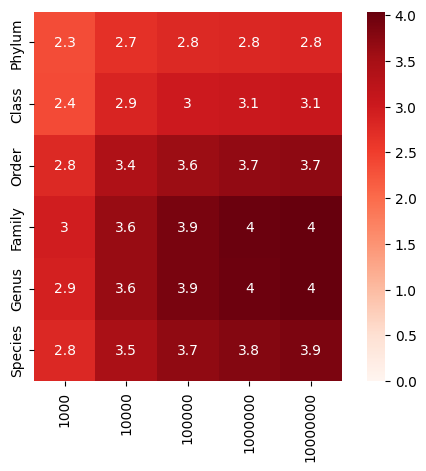

In [12]:
sns.heatmap(pama_shannon_mean.iloc[1:],
            cmap='Reds',
            vmin=0,
            #vmax = 10,
            annot =True,
            square = True,
           )

In [13]:
## combine PAMA-seq data by taxon at differnt levels
for t in taxa_up:
    cmb_df =  pd.read_csv(out_dir + 'ocean_pam_subsample_read_cnt_by_{}.csv'.format(t), index_col = 0 ) # load data by the taxon

    # initialize the dataframes
    cmb_rel_by_read_cnt = pd.DataFrame(index = cmb_df.index)
    cmb_rel_by_read_cnt_err = pd.DataFrame(index = cmb_df.index)
    min_rel_abd = pd.DataFrame(index = [t])
    total_rel_abd = pd.DataFrame(index = [t])

    for cnt in cnt_depths:
        sub_cnt_df = cmb_df.loc[:, cmb_df.columns.str.startswith('ocean_combined_'+str(cnt)+'_')]

        cmb_rel_by_read_cnt[cnt]= sub_cnt_df.T.mean()
   
        cmb_rel_by_read_cnt_err[cnt] = sub_cnt_df.T.std()
        min_rel_abd[cnt] = sub_cnt_df.T.min().min()
        total_rel_abd[cnt] = sub_cnt_df.sum().mean()

    # sort the values
    cmb_rel_by_read_cnt['sum'] = cmb_rel_by_read_cnt.sum(axis=1)
    cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.sort_values(by='sum', ascending=False)
    cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.drop(columns='sum')
    
    # remove empty rows
    cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.dropna(how='all')
    cmb_rel_by_read_cnt_err = cmb_rel_by_read_cnt_err.loc[cmb_rel_by_read_cnt.index]

    # save the data
    cmb_rel_by_read_cnt.to_csv(out_dir + '{}_pam-seq_combined_relative_abundance_by_read_count.csv'.format(t))
    cmb_rel_by_read_cnt_err.to_csv(out_dir + '{}_pam-seq_combined_relative_abundance_error_by_read_count.csv'.format(t))
    min_rel_abd.to_csv(out_dir + '{}_pam-seq_minimal_relative_abundance_by_read_count.csv'.format(t))
    total_rel_abd.to_csv(out_dir + '{}_pam-seq_total_annotated_relative_abundance_by_read_count.csv'.format(t))

    


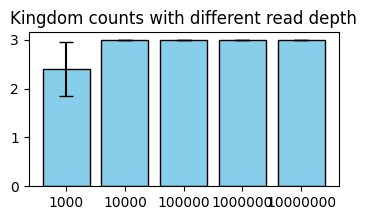

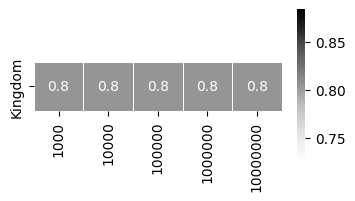

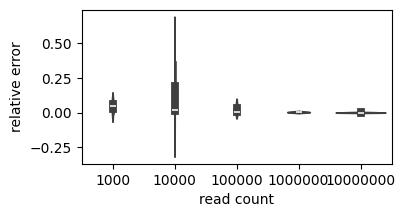

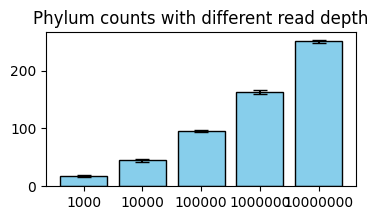

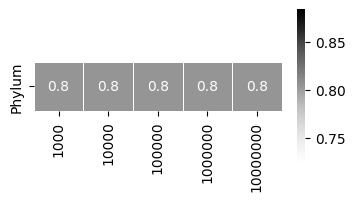

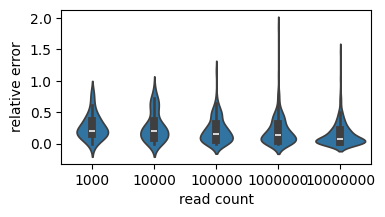

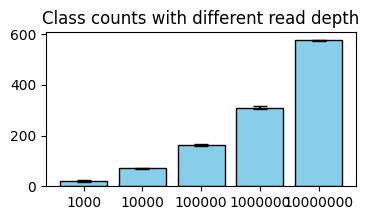

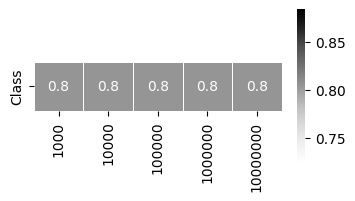

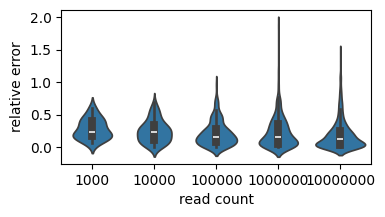

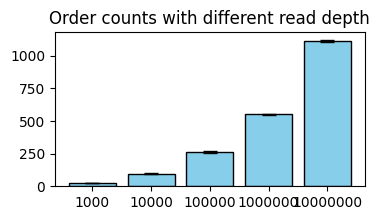

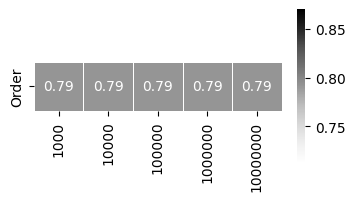

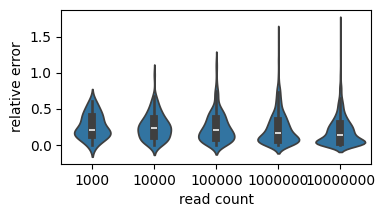

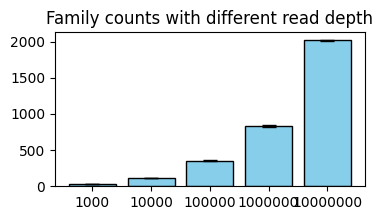

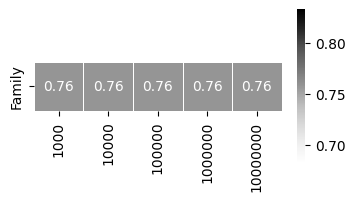

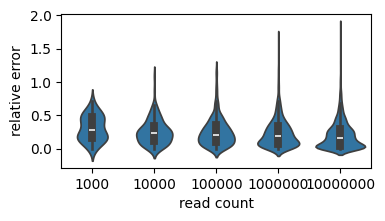

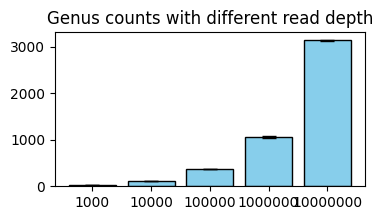

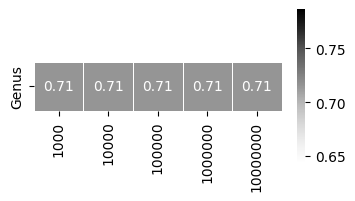

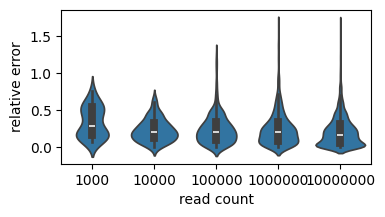

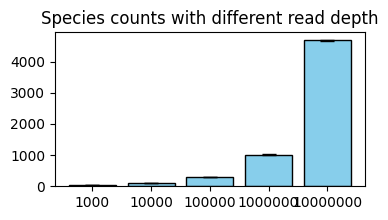

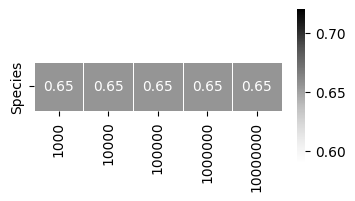

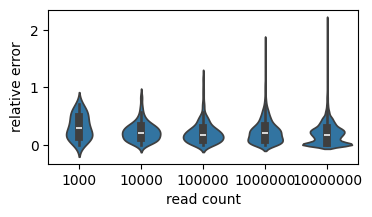

In [14]:
# plot the taxon counts, total abundance, and the relative errors. 
for t in taxa_up:
    cmb_df =  pd.read_csv(out_dir + 'ocean_pam_subsample_read_cnt_by_{}.csv'.format(t), index_col = 0 ) # load data by the taxon
    cmb_rel_by_read_cnt = pd.read_csv(out_dir + '{}_pam-seq_combined_relative_abundance_by_read_count.csv'.format(t), index_col =0)
    cmb_rel_by_read_cnt_err = pd.read_csv(out_dir + '{}_pam-seq_combined_relative_abundance_error_by_read_count.csv'.format(t), index_col =0)
    min_rel_abd = pd.read_csv(out_dir + '{}_pam-seq_minimal_relative_abundance_by_read_count.csv'.format(t), index_col =0)
    total_rel_abd = pd.read_csv(out_dir + '{}_pam-seq_total_annotated_relative_abundance_by_read_count.csv'.format(t), index_col =0)

    cmb_taxon_cnt = pd.DataFrame(index = [t])
    cmb_taxon_cnt_err = pd.DataFrame(index = [t])
    
    total_rel_abd = pd.DataFrame(index = [t])

    for cnt in cnt_depths:
        cmb_taxon_cnt[cnt] = cmb_df.count().loc[cmb_df.columns.str.startswith('ocean_combined_'+str(cnt)+'_')].mean()
        cmb_taxon_cnt_err[cnt] = cmb_df.count().loc[cmb_df.columns.str.startswith('ocean_combined_'+str(cnt)+'_')].std()

        total_rel_abd.loc[t, cnt] = cmb_df.sum().mean()
        
    cmb_taxon_cnt.to_csv(out_dir + 'ocean_pam_{}_level_taxa_count.csv'.format(t))
    cmb_taxon_cnt_err.to_csv(out_dir + 'ocean_pam_{}_level_taxa_count_error.csv'.format(t))

    # Extract values (first row, since each has only one row)
    values = cmb_taxon_cnt.iloc[0]
    errors = cmb_taxon_cnt_err.iloc[0]

    # Plotting
    plt.figure(figsize=(4,2))
    bars = plt.bar(values.index.astype('str'), values.values, yerr=errors.values, capsize=5, color='skyblue', edgecolor='black')

    # Customizing the plot
    plt.title('{} counts with different read depth'.format(t))

    # Show the plot

    plt.savefig(out_dir+'{}_czid_ocean_subsample_taxon_count.pdf'.format(t), )
    plt.show()

    
    ## plot the heatmap of the total read that mapped to database
    
    plt.figure(figsize=(4,2))
    sns.heatmap(total_rel_abd,
            #vmin =0,
            #vmax = 1,
            square = True,
            linewidths=0.5,
            annot = True,
            cmap = 'Grays',
            
           )
    plt.savefig(out_dir+'{}_persentage_reads_annotated_heatmap.pdf'.format(t), )
    plt.show()

    rel_error = cmb_rel_by_read_cnt_err/cmb_rel_by_read_cnt
    rel_error = rel_error.reset_index().melt(id_vars=[t], var_name = 'read count', value_name = 'relative error')
    rel_error['read count'] = rel_error['read count'].astype(str)
    plt.figure(figsize=(4,2))
    sns.violinplot(data = rel_error,
               x = 'read count',
               y = 'relative error',
              )
    #plt.ylim(0, 1)
    plt.savefig(out_dir+'{}_relative_error_violin.pdf'.format(t), )
    plt.show()
    rel_error.to_csv(out_dir+ 'pam-seq_ocean_{}_relative_error_for_violin_plot.csv'.format(t))

## Metagenomic subsamples
### Kaiju 

In [16]:
taxa = ['phylum', 'class', 'order', 'family', 'genus', 'species'] 
read_cnts = ['1K', '10K', '100K', '1M', '10M']

In [17]:
for t in taxa:
    cmb_df = pd.DataFrame(columns =['taxon_id']) ## combined df 
   
    for cnt in read_cnts:
        for i in [1, 2, 3, 4, 5]:
            f = wk_dir + '{}_{}-{}-longtail.kaijuReport'.format(cnt, i, t)
            try:
                df = pd.read_csv(f, sep= '\t')
                df = df.set_index('taxon_name')
                df = df.rename(columns={'reads':'{}_{}-{}'.format(cnt, i, t)})
                cmb_df = pd.concat([cmb_df,df[['{}_{}-{}'.format(cnt, i, t)]]], axis=1)
                cmb_df.loc[df.index, 'taxon_id'] = df['taxon_id'].astype('str')
                
                
            except FileNotFoundError:
                print('file {} not found'.format(f))
    cmb_df = cmb_df.fillna(0)
    cmb_df.to_csv(wk_dir + 'ocean_{}_level_kaiju_read_counts.csv'.format(t))

file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-phylum-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-class-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-order-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-family-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-genus-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-species-longtail.kaijuReport not found


In [18]:
for t in taxa:

    cmb_df=pd.read_csv(wk_dir + 'ocean_{}_level_kaiju_read_counts.csv'.format(t), index_col=0)

    cmb_rel = cmb_df.drop(columns = ['taxon_id'])/cmb_df.drop(columns = ['taxon_id']).sum()
    cmb_rel = cmb_rel.replace(0, np.nan)
    cmb_rel = cmb_rel.drop(index = ['cannot be assigned to a (non-viral) {}'.format(t), 'unclassified'])
    

    cmb_rel_by_read_cnt = pd.DataFrame(index = cmb_rel.index)
    cmb_rel_by_read_cnt_err = pd.DataFrame(index = cmb_rel.index)
    min_rel_abd = pd.DataFrame(index = [t])
    total_rel_abd = pd.DataFrame(index = [t])
    read_cnts = ['1K', '10K', '100K', '1M', '10M']

    for cnt in read_cnts:
        cmb_rel_by_read_cnt[cnt]= cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.mean()
   
        cmb_rel_by_read_cnt_err[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.std()
        min_rel_abd[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.min().min()
        total_rel_abd[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].sum().mean()


    cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.replace(0, np.nan)
    cmb_rel_by_read_cnt_err =cmb_rel_by_read_cnt_err.replace(0, np.nan)

    cmb_rel_by_read_cnt.to_csv(out_dir + '{}_kaiju_combined_relative_abundance_by_read_count.csv'.format(t))
    cmb_rel_by_read_cnt_err.to_csv(out_dir + '{}_kaiju_combined_relative_abundance_error_by_read_count.csv'.format(t))
    min_rel_abd.to_csv(out_dir + '{}_kaiju_minimal_relative_abundance_by_read_count.csv'.format(t))
    total_rel_abd.to_csv(out_dir + '{}_kaiju_total_annotated_relative_abundance_by_read_count.csv'.format(t))


    rel_error = cmb_rel_by_read_cnt_err/cmb_rel_by_read_cnt
    
    rel_error = rel_error.reset_index().melt(id_vars='index', var_name = 'read count', value_name = 'relative error')
    rel_error = rel_error.rename(columns = {"index": t.lower()})
    rel_error['read count'] = rel_error['read count'].astype(str)
    rel_error.to_csv(out_dir+ 'kaiju_ocean_{}_relative_error_for_violin_plot.csv'.format(t))

### CZID

In [23]:
nr_df = pd.read_csv(wk_dir+'ocean_czi_nr_count_all_subsamples.csv', index_col=0)
nt_df = pd.read_csv(wk_dir+'ocean_czi_nt_count_all_subsamples.csv', index_col=0)

In [24]:
['1000_1_nr_rpm', '1000_2_nr_rpm', '1000_3_nr_rpm', '1000_4_nr_rpm',
       '1000_5_nr_rpm', '10000_1_nr_rpm', '10000_2_nr_rpm', '10000_3_nr_rpm',
       '10000_4_nr_rpm', '10000_5_nr_rpm', '100000_1_nr_rpm',
       '100000_2_nr_rpm', '100000_3_nr_rpm', '100000_4_nr_rpm',
       '100000_5_nr_rpm', '1000000_1_nr_rpm', '1000000_2_nr_rpm',
       '1000000_3_nr_rpm', '1000000_4_nr_rpm', '1000000_5_nr_rpm',
       '10000000_1_nr_rpm', '10000000_2_nr_rpm', '10000000_3_nr_rpm',
       '10000000_4_nr_rpm', '10000000_5_nr_rpm']

['1000_1_nr_rpm',
 '1000_2_nr_rpm',
 '1000_3_nr_rpm',
 '1000_4_nr_rpm',
 '1000_5_nr_rpm',
 '10000_1_nr_rpm',
 '10000_2_nr_rpm',
 '10000_3_nr_rpm',
 '10000_4_nr_rpm',
 '10000_5_nr_rpm',
 '100000_1_nr_rpm',
 '100000_2_nr_rpm',
 '100000_3_nr_rpm',
 '100000_4_nr_rpm',
 '100000_5_nr_rpm',
 '1000000_1_nr_rpm',
 '1000000_2_nr_rpm',
 '1000000_3_nr_rpm',
 '1000000_4_nr_rpm',
 '1000000_5_nr_rpm',
 '10000000_1_nr_rpm',
 '10000000_2_nr_rpm',
 '10000000_3_nr_rpm',
 '10000000_4_nr_rpm',
 '10000000_5_nr_rpm']

In [25]:
read_cnts = ['1000', '10000', '100000', '1000000', '10000000']
for method in ['nt', 'nr']:
    cols = []
    for cnt in  read_cnts:
        
        for rep in [1,2,3,4,5]:
            cols.append('{}_{}_{}_rpm'.format(cnt, rep, method))
    # read the file:
    czid_df = pd.read_csv(wk_dir+'ocean_czi_{}_count_all_subsamples.csv'.format(method), index_col=0)
    # combine the file by taxon
    for t in ['phylum', 'class','order', 'family', 'genus', 'species']:
        cmb_df = czid_df.groupby(t)[cols].sum()
        #cmb_df = cmb_df.replace(0, np.nan)
        cmb_df = cmb_df.dropna(axis=0, how='all')
        cmb_df.to_csv(out_dir + "czid_{}_combined_at_{}_level.csv".format(method, t))

        cmb_rel = cmb_df/cmb_df.sum()
        cmb_rel = cmb_rel.replace(0, np.nan)
        cmb_rel.to_csv(out_dir + "czid_{}_combined_at_{}_level_relative_abd.csv".format(method, t))
        
        cmb_rel_by_read_cnt = pd.DataFrame(index = cmb_rel.index)
        cmb_rel_by_read_cnt_err = pd.DataFrame(index = cmb_rel.index)
        min_rel_abd = pd.DataFrame(index = [t])
        total_rel_abd = pd.DataFrame(index = [t])
        

        for cnt in read_cnts:
            cmb_rel_by_read_cnt[cnt]= cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.mean()
   
            cmb_rel_by_read_cnt_err[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.std()
            min_rel_abd[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.min().min()
            total_rel_abd[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].sum().mean()

        cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.replace(0, np.nan)
        cmb_rel_by_read_cnt_err =cmb_rel_by_read_cnt_err.replace(0, np.nan)

        cmb_rel_by_read_cnt.to_csv(out_dir + '{}_czid_{}_combined_relative_abundance_by_read_count.csv'.format(t,method))
        cmb_rel_by_read_cnt_err.to_csv(out_dir + '{}_czid_{}_combined_relative_abundance_error_by_read_count.csv'.format(t,method))
        min_rel_abd.to_csv(out_dir + '{}_czid_{}_minimal_relative_abundance_by_read_count.csv'.format(t,method))
        total_rel_abd.to_csv(out_dir + '{}_czid_{}_total_annotated_relative_abundance_by_read_count.csv'.format(t,method))   
        rel_error=pd.DataFrame()
        rel_error = cmb_rel_by_read_cnt_err/cmb_rel_by_read_cnt
    
        rel_error = rel_error.reset_index().melt(id_vars=t.lower(), var_name = 'read count', value_name = 'relative error')
        rel_error['read count'] = rel_error['read count'].astype(str)
        rel_error.to_csv(out_dir+ 'czid_{}_ocean_{}_relative_error_for_violin_plot.csv'.format(method, t))
        print(method, t, rel_error['relative error'].mean())




nt phylum 0.4911374954647645
nt class 0.5080278021629675
nt order 0.5481366942866404
nt family 0.538427354102523
nt genus 0.5688008691566423
nt species 0.5920693158700799
nr phylum 0.5133569324891247
nr class 0.46953699285567535
nr order 0.537795966804708
nr family 0.5753783321011892
nr genus 0.5996928967360796
nr species 0.5893846549014112


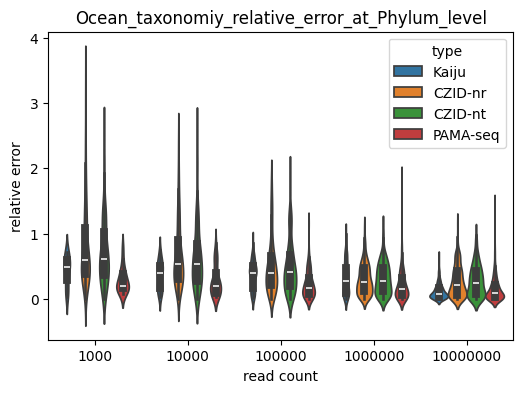

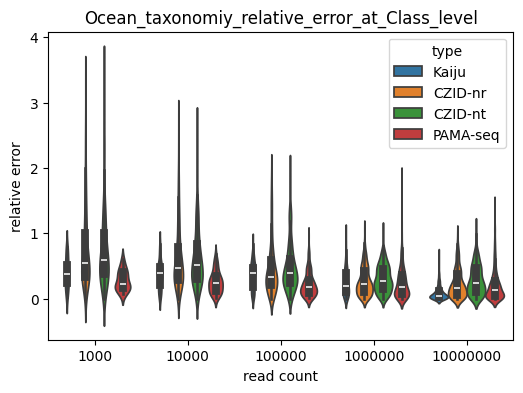

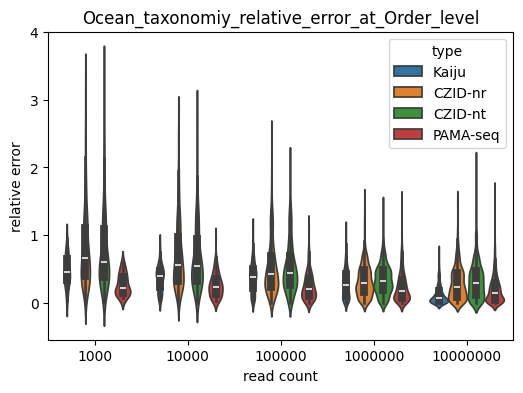

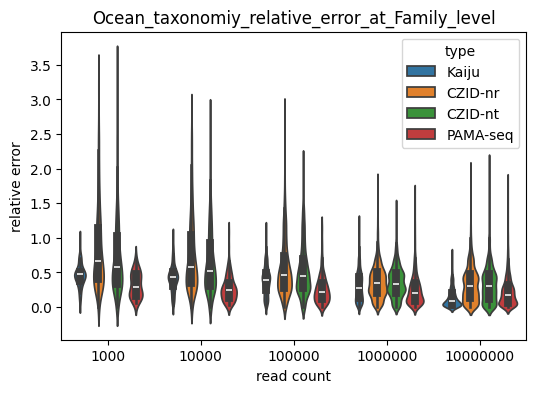

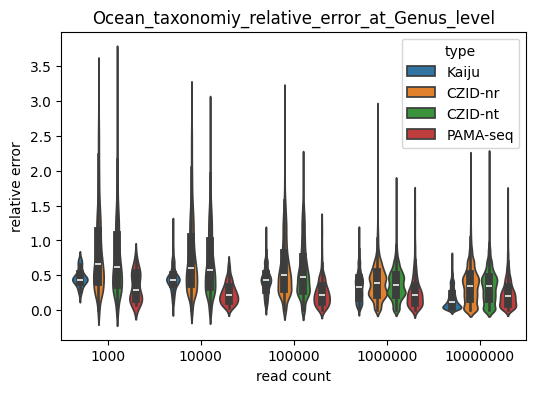

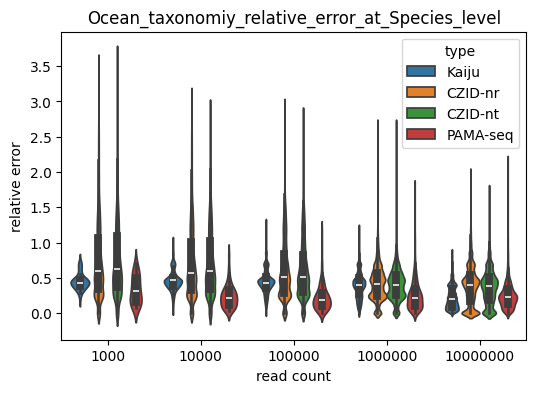

In [26]:
read_cnt_dict = {'1K': 1000, '10K': 10000, '100K': 100000, '1M':1000000, '10M': 10000000}

for t in taxa_up[1:]:
    kaiju_error = pd.read_csv(out_dir + 'kaiju_ocean_{}_relative_error_for_violin_plot.csv'.format(t.lower()), index_col = 0)
    nr_error = pd.read_csv(out_dir+ 'czid_nr_ocean_{}_relative_error_for_violin_plot.csv'.format( t.lower()), index_col = 0)
    nt_error = pd.read_csv(out_dir+ 'czid_nt_ocean_{}_relative_error_for_violin_plot.csv'.format( t.lower()), index_col = 0)
    pam_error = pd.read_csv(out_dir+ 'pam-seq_ocean_{}_relative_error_for_violin_plot.csv'.format(t), index_col = 0)
    #kaiju_error = kaiju_error.rename(columns = {'index': t.lower()})
    pam_error = pam_error.rename(columns = {t:t.lower()})
    
    kaiju_error = kaiju_error.rename(columns = read_cnt_dict)
    kaiju_error = kaiju_error.dropna(axis=0, how='all')
    kaiju_error.index.name = t.lower()
    

    kaiju_error['read count'] = kaiju_error['read count'].map(read_cnt_dict)
    
    kaiju_error['type'] = 'Kaiju'
    nr_error['type'] = 'CZID-nr'
    nt_error['type'] = 'CZID-nt'
    pam_error['type'] = 'PAMA-seq'

    combined_df = pd.concat([kaiju_error, nr_error, nt_error, pam_error], axis=0)
    combined_df = combined_df.reset_index(drop=True)
    combined_df = combined_df[(combined_df['relative error'] != 0) & (~combined_df['relative error'].isna())]
    combined_df.to_csv(out_dir + 'ocean_{}_level_error_combined_all.csv'.format(t))

    plt.figure(figsize=(6,4))
    sns.violinplot(data = combined_df,
                   x = 'read count',
                   y = 'relative error',
                   hue = 'type',              
              )
    #plt.ylim(0, 1)
    plt.title('Ocean_taxonomiy_relative_error_at_{}_level'.format(t))
    plt.savefig(out_dir+'ocean_{}_relative_error_combined_violin.pdf'.format(t,), )
    plt.show()

    

#### Shannon index

In [30]:
kaiju_shannon = pd.DataFrame()
nr_shannon = pd.DataFrame()
nt_shannon = pd.DataFrame()
pama_shannon = pd.DataFrame()
for t in taxa_up[1:]:
    kaiju_cmb_rel_by_read_cnt=pd.read_csv(out_dir + '{}_kaiju_combined_relative_abundance_by_read_count.csv'.format(t.lower()), index_col=0)
    kaiju_shannon[t.lower()] = kaiju_cmb_rel_by_read_cnt.apply(shannon_entropy, axis=0)
    nr_cmb_rel_by_read_cnt=pd.read_csv(out_dir + '{}_czid_nr_combined_relative_abundance_by_read_count.csv'.format(t.lower()), index_col=0)
    nr_shannon[t.lower()] = nr_cmb_rel_by_read_cnt.apply(shannon_entropy, axis=0)
    nt_cmb_rel_by_read_cnt=pd.read_csv(out_dir + '{}_czid_nt_combined_relative_abundance_by_read_count.csv'.format(t.lower()), index_col=0)
    nt_shannon[t.lower()] = nt_cmb_rel_by_read_cnt.apply(shannon_entropy, axis=0)
    pama_cmb_rel_by_read_cnt = pd.read_csv(out_dir + '{}_pam-seq_combined_relative_abundance_by_read_count.csv'.format(t), index_col =0)
    pama_shannon[t.lower()] = pama_cmb_rel_by_read_cnt.apply(shannon_entropy, axis=0)

    

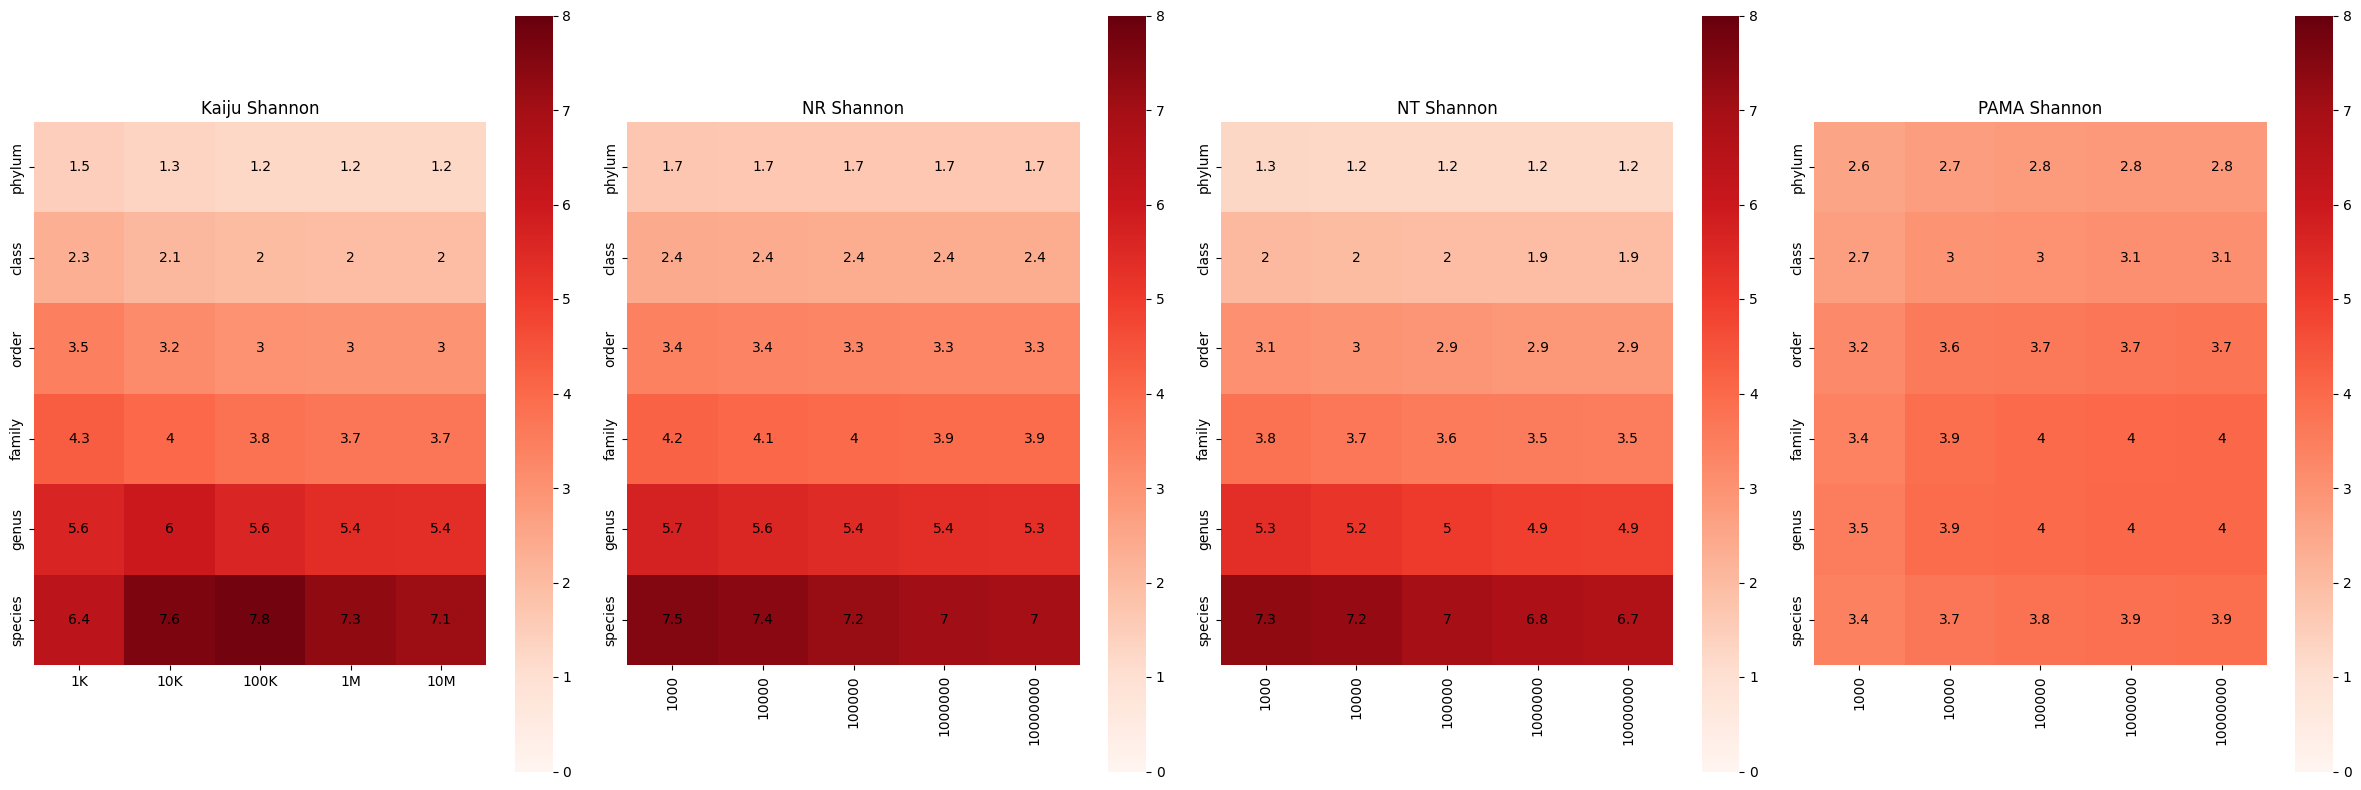

In [46]:
## PLot shannon index at different levels for the 4 methods.
# Set up the figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(24, 8))  # Wider figure to accommodate square plots

# Common heatmap settings

heatmap_kwargs = {
    'cmap': 'Reds',
    'square': True,
    'annot': True,
    'vmin': 0,
    'vmax':8,
    'annot_kws': {'color': 'black'}
}
# Plot each heatmap
sns.heatmap(kaiju_shannon.T, ax=axes[0], **heatmap_kwargs)
axes[0].set_title('Kaiju Shannon')

sns.heatmap(nr_shannon.T, ax=axes[1], **heatmap_kwargs)
axes[1].set_title('NR Shannon')

sns.heatmap(nt_shannon.T, ax=axes[2], **heatmap_kwargs)
axes[2].set_title('NT Shannon')

sns.heatmap(pama_shannon.T, ax=axes[3], **heatmap_kwargs)
axes[3].set_title('PAMA Shannon')

# Optional: improve layout
plt.tight_layout()
plt.savefig(out_dir+'shannon_index_ocean_subsample_four_methods.pdf')
plt.show()


## Alpha Diversity Analysis

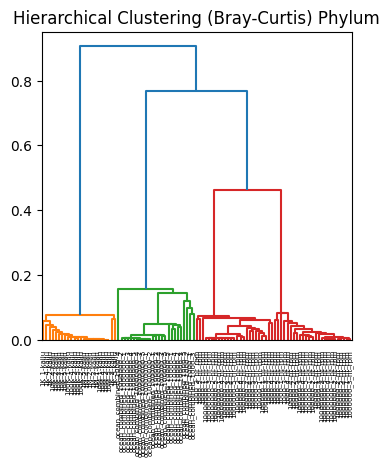

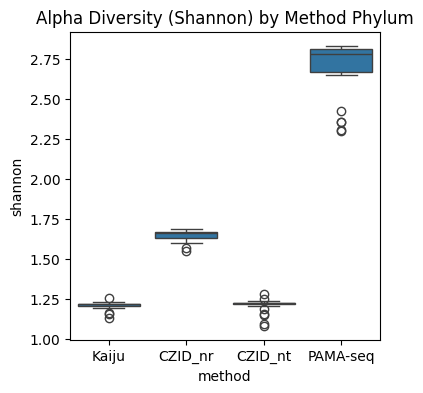

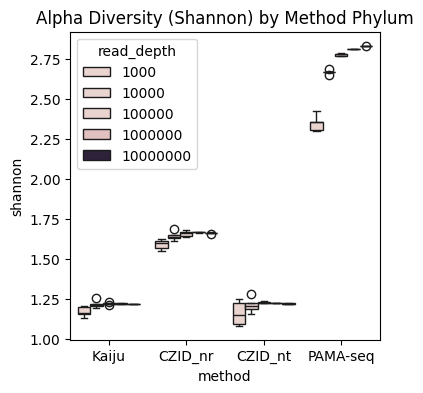

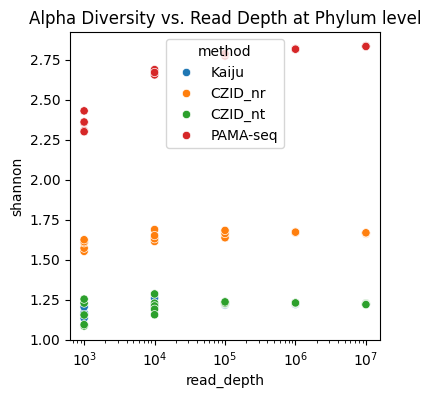

ANOVA result: F_onewayResult(statistic=np.float64(1266.4755928607328), pvalue=np.float64(1.92645457872036e-76))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.20275556835602324), pvalue=np.float64(0.04414322908887413))
ANOSIM result for Method: method name               ANOSIM
test statistic name            R
sample size                   99
number of groups               4
test statistic               1.0
p-value                    0.001
number of permutations       999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.023058066141361352), np.float64(0.173), 99)
Mantel test result: (np.float64(-0.023058066141361352), np.float64(0.179), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.018378703457848426 and the largest is 14.171883642992313.
  warn(


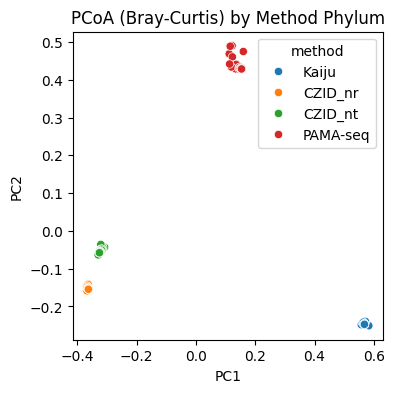

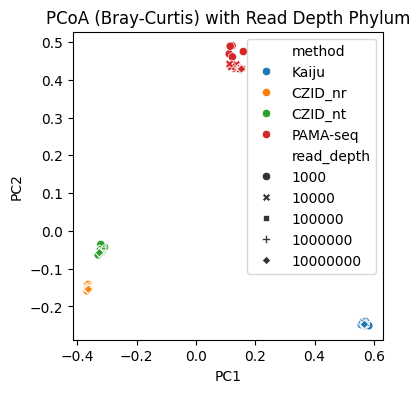

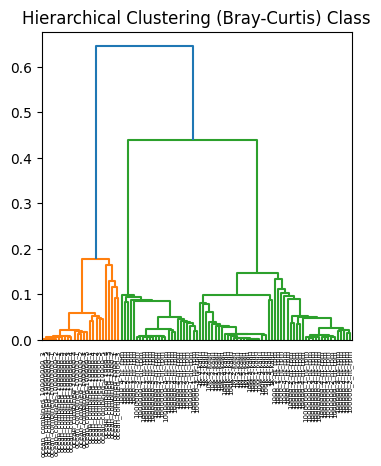

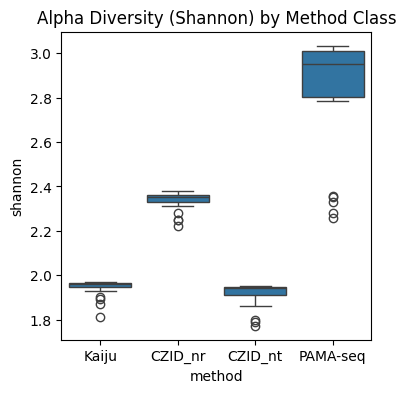

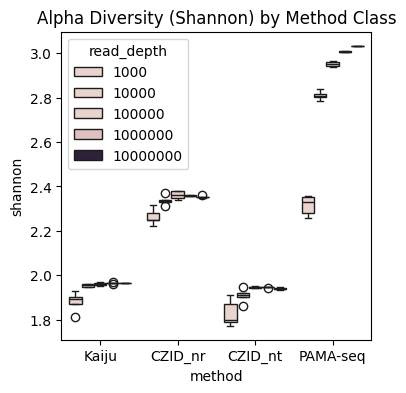

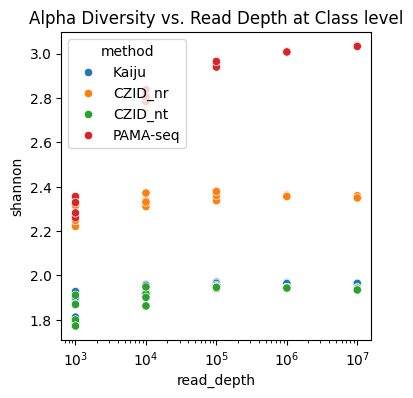

ANOVA result: F_onewayResult(statistic=np.float64(223.0649998484397), pvalue=np.float64(7.1727758590625496e-43))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.30485919272706624), pvalue=np.float64(0.002153720291626451))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.971587
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.016865983918610994), np.float64(0.64), 99)
Mantel test result: (np.float64(-0.016865983918610994), np.float64(0.613), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.018749861561320483 and the largest is 6.929455961855616.
  warn(


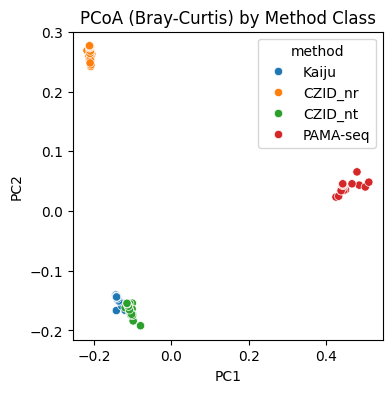

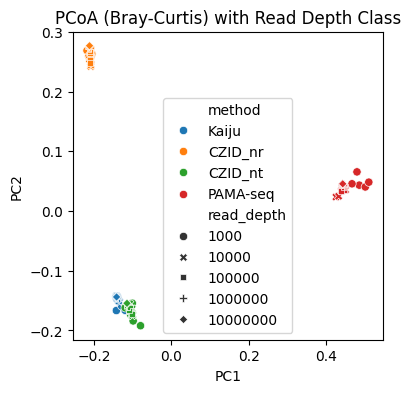

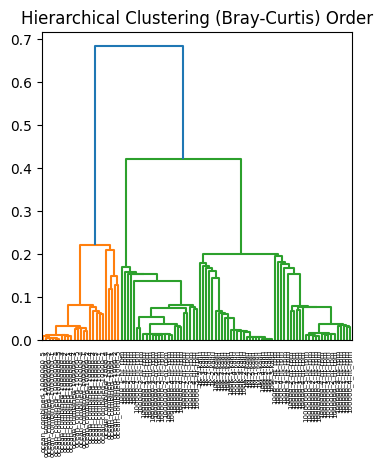

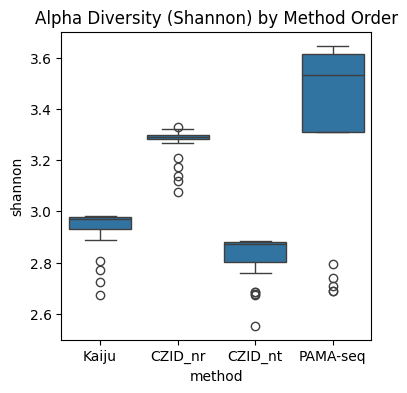

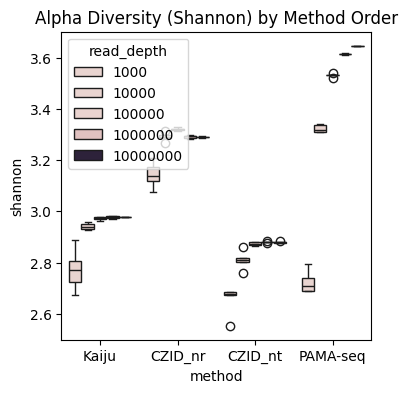

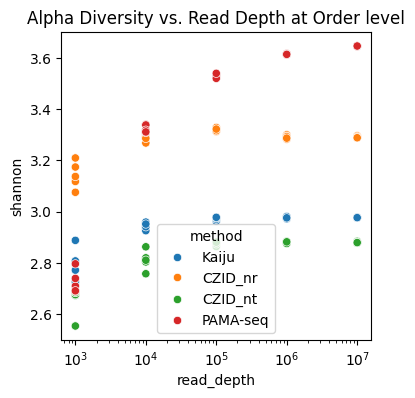

ANOVA result: F_onewayResult(statistic=np.float64(48.106016599141896), pvalue=np.float64(5.343607524627119e-19))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.43350963320150343), pvalue=np.float64(7.386540684994855e-06))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.962966
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.024258988720598437), np.float64(0.488), 99)
Mantel test result: (np.float64(-0.024258988720598437), np.float64(0.503), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02440148483019345 and the largest is 7.745771120446699.
  warn(


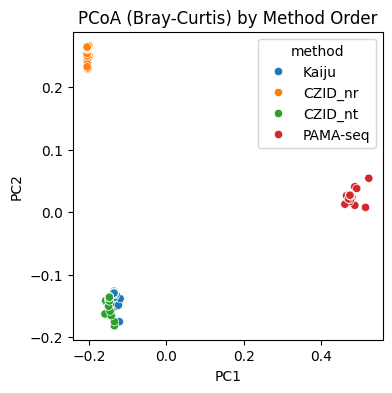

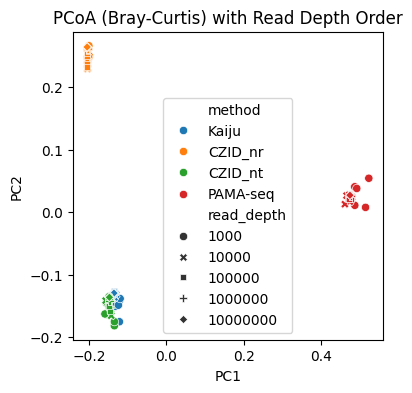

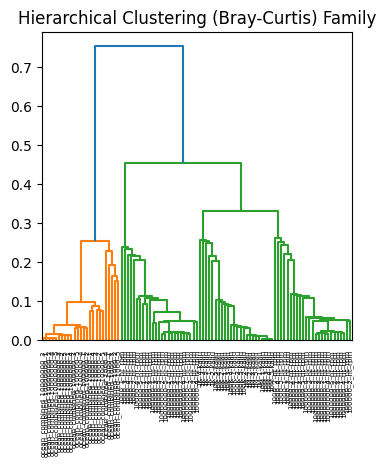

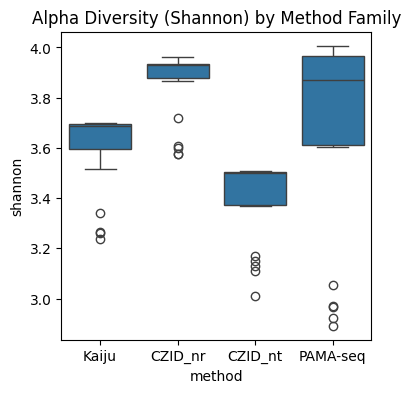

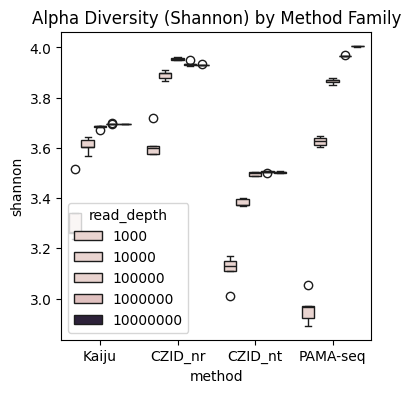

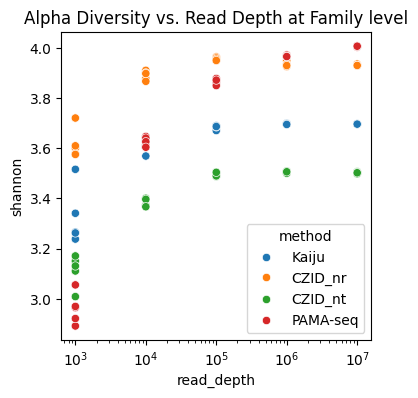

ANOVA result: F_onewayResult(statistic=np.float64(16.776747183978934), pvalue=np.float64(7.982234506921272e-09))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.5790500593850902), pvalue=np.float64(3.4181395853208357e-10))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.998725
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.03567757804861417), np.float64(0.255), 99)
Mantel test result: (np.float64(-0.03567757804861417), np.float64(0.264), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03908915256529936 and the largest is 9.230426705331864.
  warn(


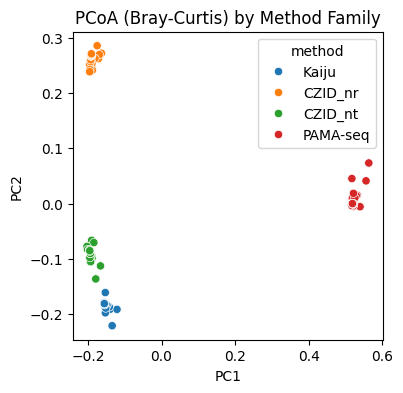

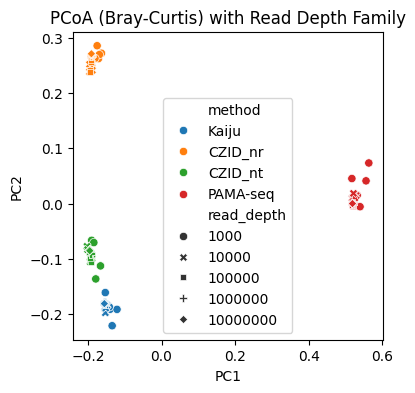

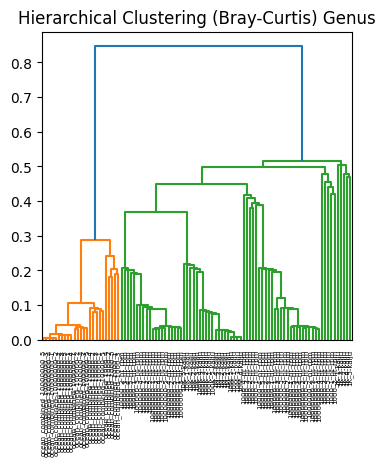

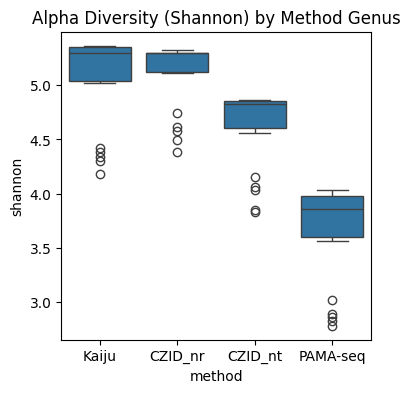

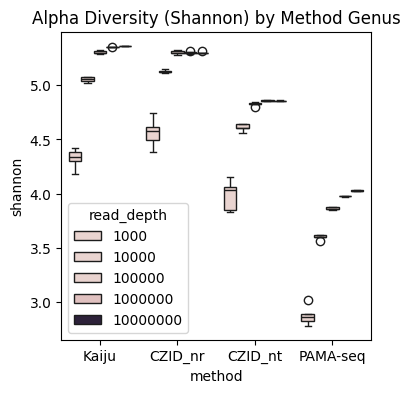

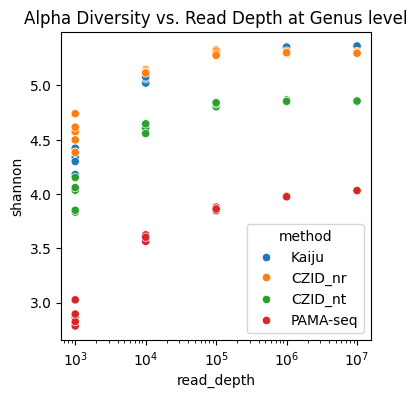

ANOVA result: F_onewayResult(statistic=np.float64(79.71246715618636), pvalue=np.float64(7.564239315060798e-26))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.46528881034857655), pvalue=np.float64(1.2193148584852824e-06))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.902282
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.05720759203546335), np.float64(0.093), 99)
Mantel test result: (np.float64(-0.05720759203546335), np.float64(0.079), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.015864607502945143 and the largest is 11.584900146223653.
  warn(


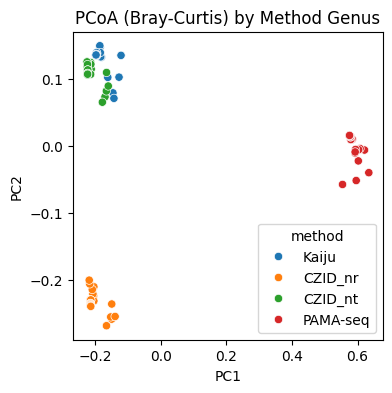

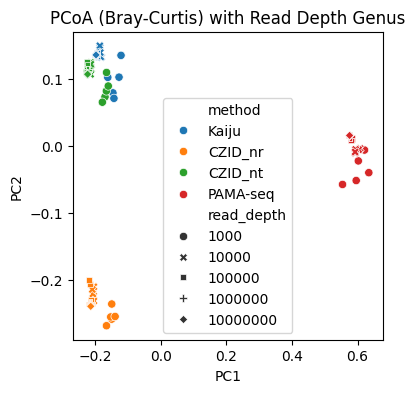

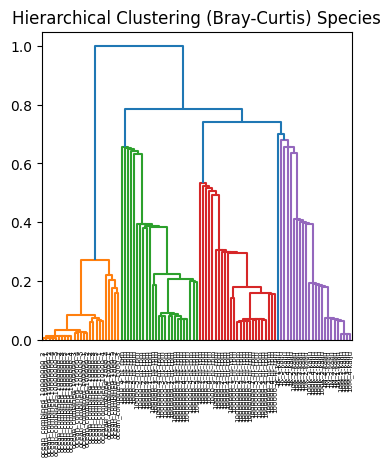

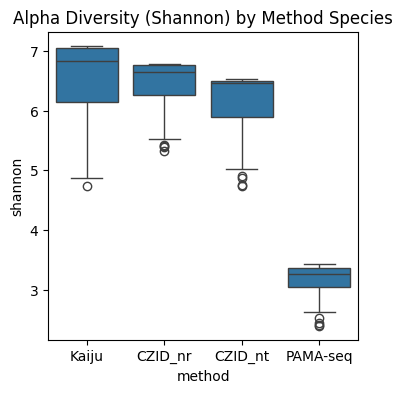

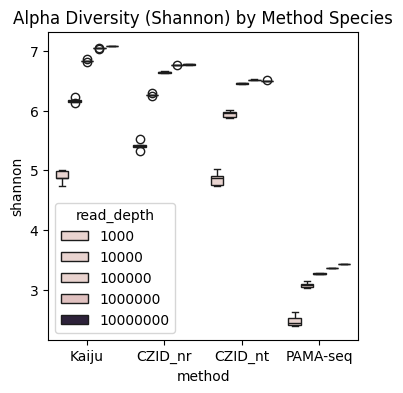

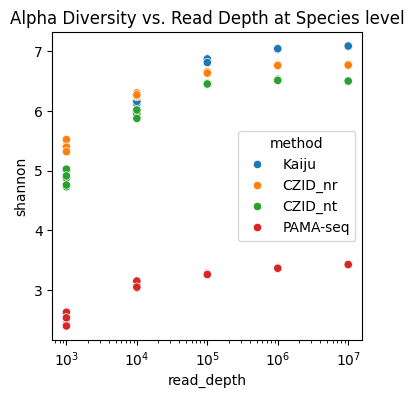

ANOVA result: F_onewayResult(statistic=np.float64(162.62029581759592), pvalue=np.float64(2.7163099324567657e-37))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.5213299849044578), pvalue=np.float64(3.153937867353662e-08))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.988894
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.055141028751248065), np.float64(0.014), 99)
Mantel test result: (np.float64(-0.055141028751248065), np.float64(0.016), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.002908485584992048 and the largest is 14.233630011776112.
  warn(


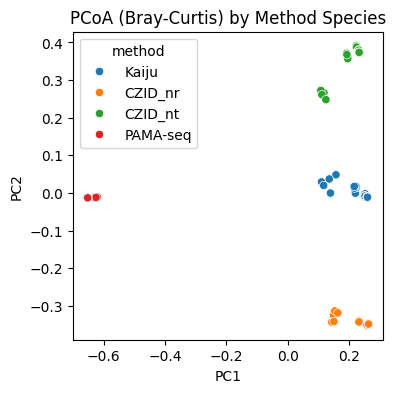

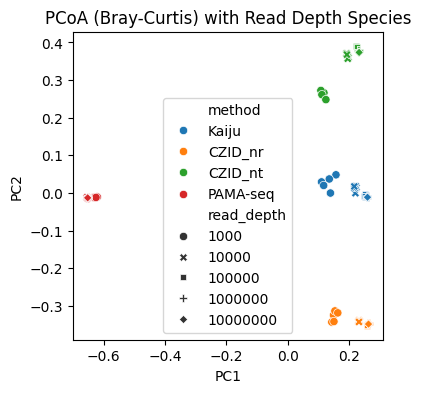

In [40]:
# plot the taxon counts, total abundance, and the relative errors. 
metadata = pd.read_csv(out_dir+ 'all_method_combined_df_metadata.csv', index_col=0)
for t in taxa_up[1:]:
    # load data by the taxon
        # load data by the taxon
    pam_cmb_df =  pd.read_csv(out_dir + 'ocean_pam_subsample_read_cnt_by_{}.csv'.format(t), index_col = 0 ) 
    kaiju_cmb_df  = pd.read_csv(wk_dir + 'ocean_{}_level_kaiju_read_counts.csv'.format(t.lower()), index_col = 0)   
    kaiju_cmb_df=kaiju_cmb_df.drop(columns = ['taxon_id'])
    kaiju_cmb_df = kaiju_cmb_df/kaiju_cmb_df.sum()
    kaiju_cmb_df = kaiju_cmb_df.drop(index = ['cannot be assigned to a (non-viral) {}'.format(t.lower()), 'unclassified'])
    kaiju_cmb_df.columns = kaiju_cmb_df.columns.str.replace(t.lower(), 'kaiju')
    nr_cmb_df  = pd.read_csv(out_dir + "czid_nr_combined_at_{}_level.csv".format(t.lower()), index_col=0)
    nt_cmb_df  = pd.read_csv(out_dir + "czid_nt_combined_at_{}_level.csv".format(t.lower()), index_col = 0)
    rel_abd_all_methods = pd.concat([kaiju_cmb_df, nr_cmb_df, nt_cmb_df, pam_cmb_df], axis =1)
    rel_abd_all_methods = rel_abd_all_methods.fillna(0) # fill empty space with 0
    rel_abd_all_methods = rel_abd_all_methods[~rel_abd_all_methods.index.str.startswith(('uncultured', 'unidentified', 'unclassified'))] # remove unclutured or unidentified taxon
    rel_abd_all_methods.to_csv('ocean_sub_sample_all_method_combined_at_{}_taxa_level.csv'.format(t), )

    df_taxa = rel_abd_all_methods.T
    df_meta = metadata
    df_taxa.index.name = 'Sample'
    df_meta.index.name = 'Sample'
    
    
    ### Analyze Alpha Diversity Across Metadata Parameters
    # Choose metric: 'shannon', 'simpson', 'observed_otus' (richness)
    alpha_metrics = ['shannon', 'simpson', 'observed_otus']

    # Calculate alpha diversity for each sample
    alpha_results = {metric: alpha_diversity(metric, df_taxa.values, df_taxa.index)
                     for metric in alpha_metrics}

    # Convert results to a DataFrame
    df_alpha = pd.DataFrame(alpha_results, index=df_taxa.index)
    


    # Compute Bray-Curtis distance matrix
    beta_metric = 'braycurtis'
    dist_matrix = beta_diversity(beta_metric, df_taxa.values, df_taxa.index)

    # Convert to a DataFrame
    df_dist = pd.DataFrame(dist_matrix.data, index=df_taxa.index, columns=df_taxa.index)
    

    # Visualize as a dendrogram
    plt.figure(figsize=(4,4))
    linkage_matrix = linkage(dist_matrix.condensed_form(), method='average')
    dendrogram(linkage_matrix, labels=df_taxa.index)
    plt.title('Hierarchical Clustering (Bray-Curtis) {}'.format(t))
    plt.savefig(out_dir+'HierarchicalClustering_{}.pdf'.format(t))
    plt.show()

    # Map metadata to sample IDs
    grouping = df_meta['method']

    # Perform ANOSIM test
    anosim_result = anosim(dist_matrix, grouping)
    # Example alpha diversity DataFrame
    df_alpha_meta = df_alpha.merge(df_meta, left_index=True, right_index=True)

    # Boxplot for Method
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df_alpha_meta, x='method', y='shannon')
    plt.title('Alpha Diversity (Shannon) by Method {}'.format(t))
    plt.savefig(out_dir+'AlphaDiversityByMethodat_{}.pdf'.format(t))
    plt.show()
     # Boxplot for Method
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df_alpha_meta, x='method', y='shannon', hue='read_depth')
    plt.title('Alpha Diversity (Shannon) by Method {}'.format(t))
    plt.savefig(out_dir+'AlphaDiversityByMethod_readdepth_at_{}.pdf'.format(t))
    plt.show()

    # Scatter plot for Read Depth
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=df_alpha_meta, x='read_depth', y='shannon', hue='method')
    plt.title('Alpha Diversity vs. Read Depth at {} level'.format(t))
    plt.xscale('log')
    plt.savefig(out_dir+'AlphaDiversity_by_read_depth_at_{}.pdf'.format(t))
    plt.show()

    ### Statistical Testing for Alpha Diversity

    # ANOVA for Method
    groups = [group['shannon'].values for _, group in df_alpha_meta.groupby('method')]
    anova_result = f_oneway(*groups)
    print('ANOVA result:', anova_result)

    # Spearman correlation with Read_Depth
    corr_result = spearmanr(df_alpha_meta['read_depth'], df_alpha_meta['shannon'])
    print('Spearman Correlation:', corr_result)


    ###  Analyze Beta Diversity Across Metadata Parameters
    
    # Grouping by Method
    grouping_method = df_meta['method']

    # Perform ANOSIM for Method
    anosim_result_method = anosim(dist_matrix, grouping_method)
    print('ANOSIM result for Method:', anosim_result_method)
    
    # Generate a distance matrix for Read Depth
    read_depth_matrix = np.abs(df_meta['read_depth'].values[:, None] - df_meta['read_depth'].values)



    # Create DistanceMatrix for read_depth_matrix
    read_depth_dist_matrix = DistanceMatrix(read_depth_matrix, ids=df_meta.index)

    # Perform Mantel test
    mantel_result = mantel(dist_matrix, read_depth_dist_matrix)
    print('Mantel test result:', mantel_result)
    
    # Create DistanceMatrix for read_depth_matrix
    read_depth_dist_matrix = DistanceMatrix(read_depth_matrix, ids=df_meta.index)

    # Perform Mantel test
    mantel_result = mantel(dist_matrix, read_depth_dist_matrix)
    print('Mantel test result:', mantel_result)
    
    ### Visualize Beta Diversity with Metadata
    # Perform PCoA on your distance matrix
    pcoa_results = pcoa(dist_matrix)

    # Convert PCoA results to a DataFrame
    df_pcoa = pcoa_results.samples
    # Add metadata to PCoA results
    df_pcoa_meta = df_pcoa.merge(df_meta, left_index=True, right_index=True)

    # Scatter plot for PCoA with Method
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=df_pcoa_meta, x='PC1', y='PC2', hue='method')
    plt.title('PCoA (Bray-Curtis) by Method {}'.format(t))
    plt.savefig(out_dir+'PCoA_by_Method_{}.pdf'.format(t))
    plt.show()
    
    # Scatter plot for PCoA with Read Depth
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=df_pcoa_meta, x='PC1', y='PC2', style='read_depth', hue='method')
    plt.title('PCoA (Bray-Curtis) with Read Depth {}'.format(t))
    plt.savefig(out_dir+'PCoA_by_read_depth_{}.pdf'.format(t))
    plt.show()




   


